#Setup (Base de dados no Google Cloud Storage)

In [ ]:
# Instalação do PySpark e do Pandera

!pip install pyspark
!pip install pandera

In [2]:
# Importar demais bibliotecas para trabalho com dados

import pandas as pd
import pandera as pa
import numpy as np

In [ ]:
# Instalação da Biblioteca Google Cloud Storage File System
!pip install gcsfs

In [ ]:
# Importar as bibliotecas necessárias

from pyspark.sql import SparkSession

import pyspark.sql.functions as F

from google.cloud import storage
import os

In [ ]:
# Configuração da chave de segurança

serviceAccount = '/content/bc26-marcos-valente-f0a95992aab3.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

In [ ]:
# Fazer o acesso ao Bucket

client = storage.Client()

# Criar uma variável para receber o nome da Bucket (como está no Storage)

bucket = client.get_bucket('bc26-datasets-marcos')

# Escolher o arquivo dentro do Bucket

bucket.blob('spotify.csv')

# Criar uma variável para receber o caminho do arquivo

path = 'gs://bc26-datasets-marcos/spotify.csv'

In [ ]:
# Criando a SparkSession com um Config adcional para coneção com Cloud Storage

spark = (
    SparkSession.builder
                .master('local')
                .appName('gcsfs') # Pode ser qualquer nome
                .config('spark.ui.port', '4050')
                .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar')
                .getOrCreate()
)

In [ ]:
# Ler o arquivo CSV que está vindo do Bucket

df = (spark.read.format('csv').option('header', 'true')
                              .option('inferschema', 'true')
                              .option('delimiter', ',')
                              .load(path) # Caminho do arquivo no Storage
)

In [ ]:
# Pré-visualização

df.show(truncate = False)

In [ ]:
# Criar backup

df_backup = df

#DOCUMENTAÇÃO

INSTRUÇÕES

1.   RENOMEAR TODAS AS COLUNAS (TRADUZINDO PARA O PORTUGUÊS)
2.   FAÇA UMA ANÁLISE INICIAL, ORDENANDO POR COLUNAS DE FORMA ASCENDENTE E DESCENDENTE
3.   VERIFIQUE SE HÁ ALGUMA COLUNA QUE NÃO TENHA INFORMAÇÃO RELEVANTE E FAÇA UM DROP 
4.   VERIFIQUE SE HÁ LINHAS DUPLICADAS (DUPLICATAS) E REMOVA-AS
5.   VERIFIQUE SE HÁ DADOS INCONSISTENTES (Dica: Unidades de medida) 
6.   REMOVA AS INCONSISTÊNCIAS
7.   VERIFIQUE OS TIPOS DE DADOS DAS COLUNAS, E COLOQUE PARA UM TIPO MAIS ADEQUADO
8.   FAÇA OUTRAS VERIFICAÇÕES DE ACORDO COM A SUA EXPERIÊNCIA EM PANDAS 

EXPLICAÇÃO DO SCHEMA
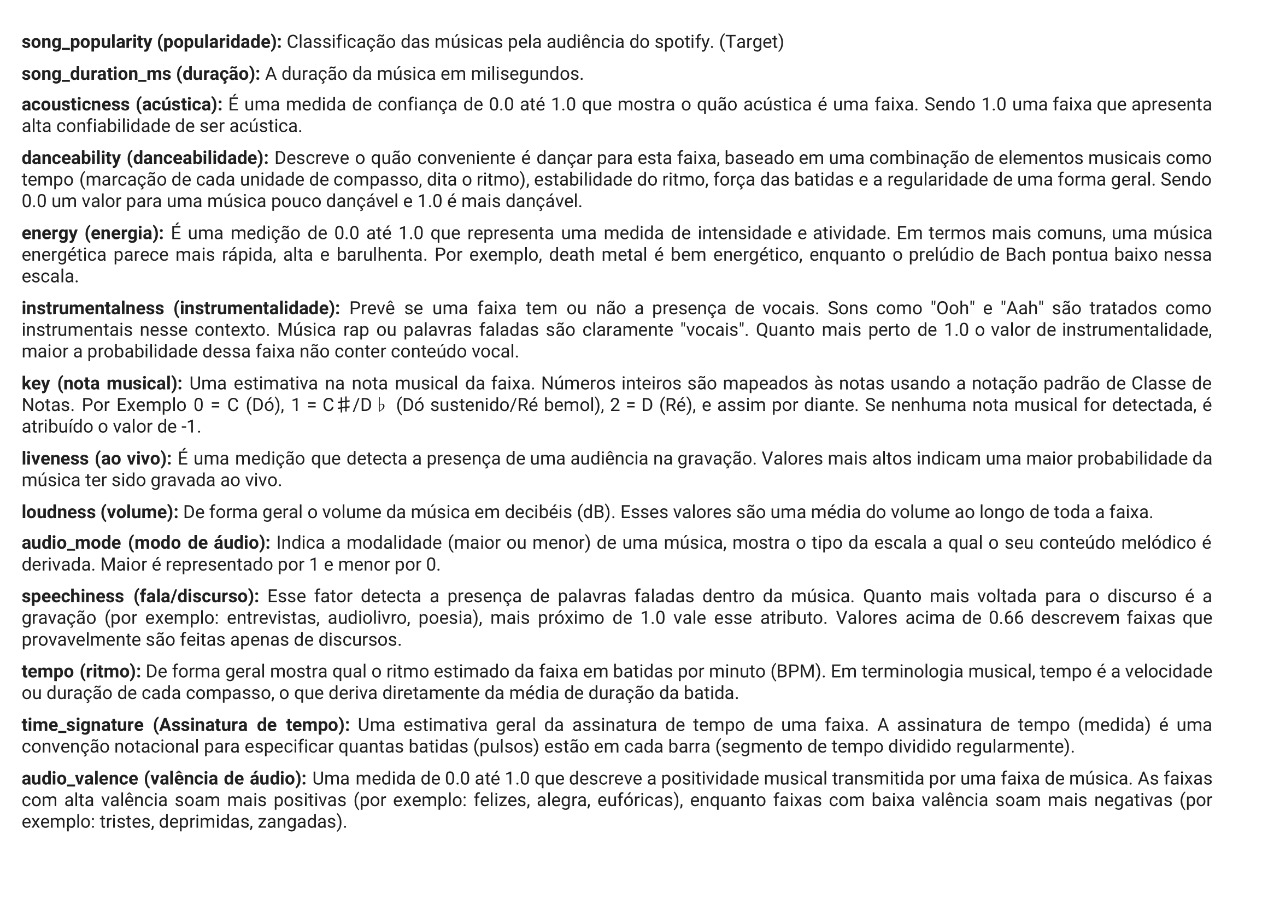

#Pré-visualização

In [ ]:
df.show(5, truncate = False)

+---+--------------------------+---------------+----------------+----------------------+------------+------------------+----------------+----+--------+-------------------+----------+-----------+-------+--------------+-------------+
|_c0|song_name                 |song_popularity|song_duration_ms|acousticness          |danceability|energy            |instrumentalness|key |liveness|loudness           |audio_mode|speechiness|tempo  |time_signature|audio_valence|
+---+--------------------------+---------------+----------------+----------------------+------------+------------------+----------------+----+--------+-------------------+----------+-----------+-------+--------------+-------------+
|0  |Boulevard of Broken Dreams|73             |262333          |0.005520000000000001kg|0.496mol/L  |0.682             |2.94e-05        |8.0 |0.0589  |-4.095             |1         |0.0294     |167.06 |4             |0.474        |
|1  |In The End                |66             |216933          |0.0103k

In [ ]:
df.count() # Foram inseridos 18835 registros (músicas)

18835

In [ ]:
df.dtypes

[('_c0', 'int'),
 ('song_name', 'string'),
 ('song_popularity', 'string'),
 ('song_duration_ms', 'string'),
 ('acousticness', 'string'),
 ('danceability', 'string'),
 ('energy', 'string'),
 ('instrumentalness', 'string'),
 ('key', 'double'),
 ('liveness', 'string'),
 ('loudness', 'string'),
 ('audio_mode', 'string'),
 ('speechiness', 'string'),
 ('tempo', 'string'),
 ('time_signature', 'string'),
 ('audio_valence', 'double')]

#Renomear colunas

In [ ]:
# RENOMEAR COLUNAS: optou-se por traduzir as colunas para nomeclatura utilizada na documentação

df = (df.withColumnRenamed('song_name','nome_musica')
        .withColumnRenamed('song_popularity', 'popularidade')
        .withColumnRenamed('song_duration_ms', 'duracao')
        .withColumnRenamed('acousticness', 'acustica')
        .withColumnRenamed('danceability', 'danceabilidade')
        .withColumnRenamed('energy', 'energia')
        .withColumnRenamed('instrumentalness', 'instrumentabilidade')
        .withColumnRenamed('key', 'nota_musical')
        .withColumnRenamed('liveness', 'ao_vivo')
        .withColumnRenamed('loudness', 'volume')
        .withColumnRenamed('audio_mode', 'modo_de_audio')
        .withColumnRenamed('speechiness', 'fala_discurso')
        .withColumnRenamed('tempo', 'ritmo')
        .withColumnRenamed('time_signature', 'assinatura_de_tempo')
        .withColumnRenamed('audio_valence','valencia_de_audio'))

# Análise inicial (busca de inconsistências notórias)

In [ ]:
# Aqui serão passados os nomes de todas as colunas, ordenando uma a uma
coluna = 'valencia_de_audio'

# Ordenamento ascendente
df.select(F.col(coluna)).orderBy(F.col(coluna)).show(truncate = False)

In [ ]:
# Ordenamento descendente
df.select(F.col(coluna)).orderBy(F.col(coluna).desc()).show(truncate = False)

In [ ]:
'''
Inconsistências notórias:

Coluna "popularidade":
* apresenta valor ' USA"""'
* apresenta valor 'nao_sei'

Coluna "duracao":
* apresenta valor '-18528908788662'
* apresenta valor '0.8220000000000001kg'

Coluna "acustica":
* dados estão em kg

Coluna "danceabilidade":
* dados estao em mol/L

Coluna "energia":
* apresenta valor 'nao_sei'

Coluna "instrumentabilidade":
* apresenta valor 'nao_sei'

Coluna "ao_vivo":
* apresenta valor '-8.575'
* apresenta valor 'nao_sei'

Coluna "volume":
* apresenta valor 'nao_sei'

Coluna "modo_de_audio":
* apresenta valor 'nao_sei'
* apresenta valor '-6.047999999999999'

Coluna "fala_discurso":
* apresenta valores '0', '0.0'
* apresenta valor '0.nao_sei'

Coluna "ritmo":
* apresenta somente valores que variam entre 99 e 100 (coluna prejudicada - deve ser dropada)
* apresenta valor 'nao_sei'
* apresenta valores 0.0 e 0.0324 

Coluna "assinatura_de_tempo":
* apresenta valor '97.01'
* apresenta valor 'nao_sei'

Coluna "valencia_de_audio":
* apresenta valor 'null'
* apresenta valor '4.0'

'''

# Tratamento da tabela

In [ ]:
# Drop coluna "ritmo" (dados praticamente constantes)

df = df.drop('ritmo')

# Drop coluna "_c0" (Será adcionado index pelo Pandas)

df = df.drop('_c0')

In [ ]:
# Verificar se existem linhas duplicadas (duplicatas)

print(f'Total de duplicatas: {df.count() - df.distinct().count()}')

Total de duplicatas: 3904


In [ ]:
# Remover duplicatas

df = df.dropDuplicates()

print(f'Foram removidas {df_backup.count() - df.count()} duplicatas.')

Foram removidas 3904 duplicatas.


# Remoção de inconsistências já detectadas

In [ ]:
# Remover "kg" dos dados da coluna "acustica"

df = df.withColumn('acustica', F.regexp_replace(F.col('acustica'), 'kg', ''))

In [ ]:
# Remover "mol/L" dos dados da coluna "danceabilidade"

df = df.withColumn('danceabilidade', F.regexp_replace(F.col('danceabilidade'), 'mol/L', ''))

In [ ]:
# Remover inconsistências pontuais já detectadas

coluna = 'valencia_de_audio'
valor_inconsistente = '4.0'
valor_modificado = 'NA'

df = df.withColumn(coluna, F.regexp_replace(F.col(coluna), valor_inconsistente, valor_modificado))

In [ ]:
df = df.fillna('NA')

In [ ]:
# Criação de novo dataframe para "guardar" alterações

df2 = df

# Mudar tipo das colunas

In [ ]:
df2.dtypes

[('nome_musica', 'string'),
 ('popularidade', 'string'),
 ('duracao', 'string'),
 ('acustica', 'string'),
 ('danceabilidade', 'string'),
 ('energia', 'string'),
 ('instrumentabilidade', 'string'),
 ('nota_musical', 'double'),
 ('ao_vivo', 'string'),
 ('volume', 'string'),
 ('modo_de_audio', 'string'),
 ('fala_discurso', 'string'),
 ('assinatura_de_tempo', 'string'),
 ('valencia_de_audio', 'string')]

In [ ]:
'''
Colunas que serão convertidas:
* popularidade: double
* duracao: int
* acustica: double
* danceabilidade: double
* energia: double
* instrumentabilidade: double
* ao_vivo: double
* volume: double
* fala_discurso: double
* valencia_de_audio: double

'''

In [ ]:
df2 = (
df2.withColumn('popularidade', df.popularidade.cast('double'))
   .withColumn('duracao', df.duracao.cast('int'))
   .withColumn('acustica', df.acustica.cast('double'))
   .withColumn('danceabilidade', df.danceabilidade.cast('double'))
   .withColumn('energia', df.energia.cast('double'))
   .withColumn('instrumentabilidade', df.instrumentabilidade.cast('double'))
   .withColumn('ao_vivo', df.ao_vivo.cast('double'))
   .withColumn('volume', df.volume.cast('double'))
   .withColumn('fala_discurso', df.fala_discurso.cast('double'))
   .withColumn('valencia_de_audio', df.valencia_de_audio.cast('double'))
)

In [ ]:
df2.dtypes

[('nome_musica', 'string'),
 ('popularidade', 'double'),
 ('duracao', 'int'),
 ('acustica', 'double'),
 ('danceabilidade', 'double'),
 ('energia', 'double'),
 ('instrumentabilidade', 'double'),
 ('nota_musical', 'double'),
 ('ao_vivo', 'double'),
 ('volume', 'double'),
 ('modo_de_audio', 'string'),
 ('fala_discurso', 'double'),
 ('assinatura_de_tempo', 'string'),
 ('valencia_de_audio', 'double')]

# Arredondando valores

Por decisão da equipe, decidiu-se arredondar os valores das colunas que contêm dados do tipo "double" para até 4 casas decimais

In [ ]:
df2 = (df2.withColumn('popularidade', F.round(F.col('popularidade'), 4))
          .withColumn('acustica', F.round(F.col('acustica'), 4))
          .withColumn('danceabilidade', F.round(F.col('danceabilidade'), 4))
          .withColumn('energia', F.round(F.col('energia'), 4))
          .withColumn('instrumentabilidade', F.round(F.col('instrumentabilidade'), 4))
          .withColumn('nota_musical', F.round(F.col('nota_musical'), 4))
          .withColumn('ao_vivo', F.round(F.col('ao_vivo'), 4))
          .withColumn('volume', F.round(F.col('volume'), 4))
          .withColumn('fala_discurso', F.round(F.col('fala_discurso'), 4))
          .withColumn('valencia_de_audio', F.round(F.col('valencia_de_audio'), 4))
          )

# Verificar outras inconsistências com Pandas





In [ ]:
# Passando dataframe para Pandas

dfpd = df2.toPandas()

In [ ]:
# Gerando backup do dataframe no Pandas

dfpd_backup = dfpd.copy()

In [ ]:
dfpd.dtypes

nome_musica             object
popularidade           float64
duracao                float64
acustica               float64
danceabilidade         float64
energia                float64
instrumentabilidade    float64
nota_musical           float64
ao_vivo                float64
volume                 float64
modo_de_audio           object
fala_discurso          float64
assinatura_de_tempo     object
valencia_de_audio      float64
dtype: object

Validação dos dados (Pandera)

In [ ]:
# Verificar quantidade de registros nulos por coluna
dfpd.isna().sum()

nome_musica              0
popularidade             2
duracao                  2
acustica                 1
danceabilidade           1
energia                  2
instrumentabilidade      2
nota_musical             0
ao_vivo                  4
volume                   1
modo_de_audio            0
fala_discurso            1
assinatura_de_tempo      0
valencia_de_audio      319
dtype: int64

In [ ]:
schema = pa.DataFrameSchema(
    columns = {
       'nome_musica': pa.Column(pa.String),
       'popularidade': pa.Column(pa.Float, nullable = True),
       'duracao': pa.Column(pa.Float, nullable = True),
       'acustica': pa.Column(pa.Float, nullable = True),
       'danceabilidade': pa.Column(pa.Float, nullable = True),
       'energia': pa.Column(pa.Float, nullable = True),
       'instrumentabilidade': pa.Column(pa.Float, nullable = True),
       'nota_musical': pa.Column(pa.Float),
       'ao_vivo': pa.Column(pa.Float, nullable = True),
       'volume': pa.Column(pa.Float, nullable = True),
       'modo_de_audio': pa.Column(pa.String, pa.Check.str_matches(r'^([0-1])?$')),
       'fala_discurso': pa.Column(pa.Float, nullable = True),
       'assinatura_de_tempo': pa.Column(pa.String, pa.Check.str_length(1,1)),
       'valencia_de_audio': pa.Column(pa.Float, nullable = True)
    }
)

In [ ]:
schema.validate(dfpd)

'''
Resultados:
- Coluna "modo_de_audio"
--- dado "0.105"

- Coluna "assinatura_de_tempo"
--- dado "2800000000"
--- dado "0.7"

'''

In [ ]:
# Corrigindo inconsistências encontradas
dfpd.modo_de_audio.replace(['0.105'], 'NA', inplace = True)

dfpd.assinatura_de_tempo.replace(['2800000000'], 'NA', inplace = True)
dfpd.assinatura_de_tempo.replace(['0.7'], 'NA', inplace = True)


Analisar valores anulados (Pandas)

* Diretriz da empresa: remover linhas que possuírem 2 ou mais dados nulos

In [ ]:
# Verificar quantidade de registros nulos por coluna
dfpd.isna().sum()

nome_musica              0
popularidade             2
duracao                  2
acustica                 1
danceabilidade           1
energia                  2
instrumentabilidade      2
nota_musical             0
ao_vivo                  4
volume                   1
modo_de_audio            0
fala_discurso            1
assinatura_de_tempo      0
valencia_de_audio      319
dtype: int64

In [ ]:
filtro_popularidade = dfpd.popularidade.isna()
dfpd.loc[filtro_popularidade]

# Remover linhas 683 e 10059

In [ ]:
dfpd.drop([683, 10059], axis = 0, inplace = True)

In [ ]:
# Verificando quais registros nulos sobraram
dfpd.isna().sum()

nome_musica              0
popularidade             0
duracao                  1
acustica                 0
danceabilidade           0
energia                  1
instrumentabilidade      2
nota_musical             0
ao_vivo                  4
volume                   1
modo_de_audio            0
fala_discurso            1
assinatura_de_tempo      0
valencia_de_audio      317
dtype: int64

In [ ]:
filtro_duracao = dfpd.duracao.isna()
dfpd.loc[filtro_duracao]

# OK

In [ ]:
filtro_energia = dfpd.energia.isna()
dfpd.loc[filtro_energia]

# OK

In [ ]:
filtro_instrumentabilidade = dfpd.instrumentabilidade.isna()
dfpd.loc[filtro_instrumentabilidade]

# OK

In [ ]:
filtro_ao_vivo = dfpd.ao_vivo.isna()
dfpd.loc[filtro_ao_vivo]

# OK

In [ ]:
filtro_volume = dfpd.volume.isna()
dfpd.loc[filtro_volume]

# OK

In [ ]:
filtro_fala_discurso = dfpd.fala_discurso.isna()
dfpd.loc[filtro_fala_discurso]

# OK

#Load dataframe tratado (PySpark)

In [ ]:
# Retornando dataframe para PySpark

df3 = spark.createDataFrame(dfpd)

In [ ]:
df3.write.format('csv').option('header', 'true').save('/content/spotify_tratado')